In [588]:
# imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from datetime import datetime
from openpyxl import load_workbook


In [589]:
# get old price data
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')
df = df['Series 28'][0:-500]

# get new price data
test = pd.read_excel('Test Bed V2.xlsm', usecols='AC', header=1)
test = test['Series 28']

#test = pd.read_excel('Time Series Data.xlsx')
#test = test['Series 28'][-500::]

In [590]:
def tradyboi(data, window_mean=12, upper_bound=0.2, lower_bound=0, cap_bound=0.9,\
             trade_size_sell=100000, trade_size_buy=50000): 

    # data - list with price data
    # window_mean - integer used in mean window
    # upper_bound - float used to find sell criteria
    # lower_bound - float used to find buy criteria
    # cap_bound - float used to find cap of buying 
    # trade_size_sell - integer for incremental amount to sell
    # trade_size_buy - integer for incremental amount to buy
    
    # constraints
    max_cap = 500000
    position = 0
    
    # create full SMA
    SMA = (100*df[-window_mean+2::]/float(df[-1:])).append(data).rolling(window=window_mean).mean()[window_mean-2::]
    cap = (100*df[-200+2::]/float(df[-1:])).append(data).rolling(window=200).mean()[200-2::] + cap_bound*df.std()
    upper_bounds = SMA + upper_bound*df.std()
    lower_bounds = SMA - lower_bound*df.std()
    
    # generating signals
    sigPriceBuy = []
    sigPriceSell = []
    run_pos = []
    trade = []
      
    for i in range(int(data.index[0]), int(data.index[-1]+1)):
        # Touch of lower bound = close sell and build long position until max trade reached
        if (data[i]<lower_bounds[i]) and (position<max_cap) and (data[i]<cap[i]):
            sigPriceBuy.append(data[i])
            sigPriceSell.append(np.nan)
            run_pos.append(position)
            position += trade_size_buy
            trade.append(trade_size_buy)
            
        elif (data[i]>upper_bounds[i]) and (position>0) and (data[i]-data[i-1]>0):
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(data[i])
            run_pos.append(position)
            if position >= trade_size_sell:
                position -= trade_size_sell
                trade.append(-trade_size_sell)
            else:
                position -= trade_size_buy
                trade.append(-trade_size_buy)

        else: 
            run_pos.append(position)
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
            trade.append(np.nan)

    return (sigPriceBuy, sigPriceSell, run_pos, trade)


In [591]:
# Placing Trade

# variables
# =========================================
window_mean = 15
upper_bound = 0.1   # number of stdv from mean
lower_bound = 0.0    # number of stdv below mean
cap_bound = 0.5    # distance above 200 day moving average for buy cap
trade_size_sell = 100000    # daily trade increment
trade_size_buy = 50000    # daily trade increment
# =========================================

#Store the buy and sell data into a variable
buy_sell_data = tradyboi(test, window_mean, upper_bound, lower_bound, cap_bound, trade_size_sell, trade_size_buy)

# format outputs
trades = pd.DataFrame(test.index)
trades['trades'] = buy_sell_data[3]

# write to excel
#load excel file
workbook = load_workbook(filename="Test Bed V2.xlsm", read_only=False, keep_vba=True)
 
#open workbook
sheet = workbook.active
 
sheet['AH1'] = 28
sheet['AO1'] = 0
sheet['AV1'] = 0

#modify the desired cell
for i in np.arange(3,trades.reset_index().index[-1]+4):
    edit1 = 'AG'+str(int(i))
    edit2 = 'AN'+str(int(i))
    edit3 = 'AU'+str(int(i))
    sheet[edit1] = trades.iloc[i-3, 1]
    sheet[edit2] = 0
    sheet[edit3] = 0
 
# save the file
workbook.save(filename="Test Bed V2.xlsm")


/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_95697/1971082267.py:17: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SMA = (100*df[-window_mean+2::]/float(df[-1:])).append(data).rolling(window=window_mean).mean()[window_mean-2::]
/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_95697/1971082267.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cap = (100*df[-200+2::]/float(df[-1:])).append(data).rolling(window=200).mean()[200-2::] + cap_bound*df.std()


/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_95697/3263463056.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax1.plot((100*df[-window_mean+2::]/float(df[-1:])).append(test).rolling(window=window_mean).mean()[window_mean-2::], label='SMA', alpha=0.8, linewidth=1)
/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_95697/3263463056.py:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax1.plot((100*df[-window_mean+2::]/float(df[-1:])).append(test).rolling(window=window_mean).mean()[window_mean-2::] + upper_bound*df.std()\
/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_95697/3263463056.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax1.plot((100*df[-window_mean+2::]/float(df[-1:])

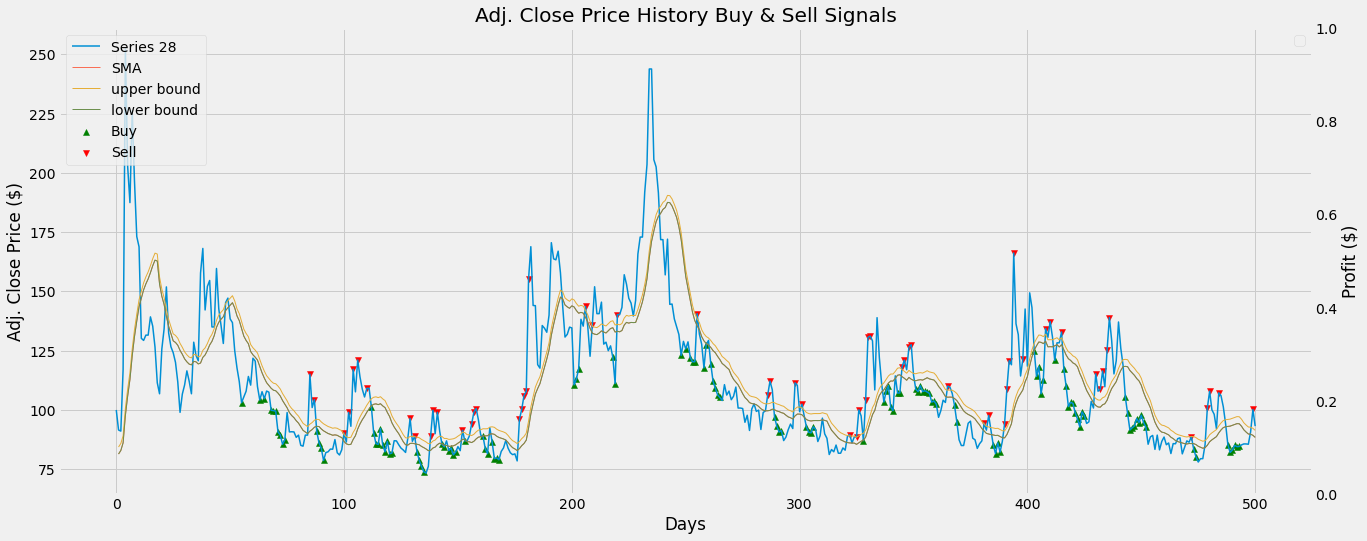

In [592]:
# Checking plotted to excel correctly
# visualise test

vix = test
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# adding price data
ax1.plot(test, label='Series 28', alpha=1, linewidth=1.5)
ax1.plot((100*df[-window_mean+2::]/float(df[-1:])).append(test).rolling(window=window_mean).mean()[window_mean-2::], label='SMA', alpha=0.8, linewidth=1)
ax1.plot((100*df[-window_mean+2::]/float(df[-1:])).append(test).rolling(window=window_mean).mean()[window_mean-2::] + upper_bound*df.std()\
         , linewidth=1, label='upper bound')
ax1.plot((100*df[-window_mean+2::]/float(df[-1:])).append(test).rolling(window=window_mean).mean()[window_mean-2::] - lower_bound*df.std()\
         , linewidth=1, label='lower bound')
#ax1.plot((100*df[-200+2::]/float(df[-1:])).append(test).rolling(window=200).mean()[200-2::] + cap_bound*df.std()\
#         , linewidth=1, label='lower bound')
# plot profit
# adding indicators
ax1.scatter(test.index, buy_sell_data[0], label='Buy', marker='^', color='green')
ax1.scatter(test.index, buy_sell_data[1], label='Sell', marker='v', color='red')
ax1.set_title('Adj. Close Price History Buy & Sell Signals')
ax1.set_xlabel('Days')
ax1.set_ylabel('Adj. Close Price ($)')
ax2.set_ylabel('Profit ($)')
ax2.grid(False)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()
